# Test-time dropout script

The goal is to develop a function with a command line interface that takes a trained model with dropout and returns an ensemble prediction, so I imagine something like:

```
python create_dropout_ensemble.py --exp_id 44-resnet_deeper2 --members 100 ...
```

The script should return and save a xarray dataset just like `create_prediction` but with an added dimension `ens_member`.

You basically already did the work in the starter exercise I gave you. You can also check out my solution. Now it's just a matter of creating a convenient script. For examples of command line scripts I wrote, check out `src/extract_level.py` using `argparse` or `scripts/download_tigge.py` using Google's `fire`. Also, see whether your or my method of implementing the test-time dropout is more convenient. Whatever requires fewer changes to the rest of the code (probably yours).

As mentioned in the WeatherBench paper, testing is done using the years 2017 and 2018. This means the ensemble predictions also have to be created for these two years. The data can be downloaded here: https://mediatum.ub.tum.de/1524895. However, the files, which contain all years, are quite large, so you probably don't want to download it to your laptop. I uploaded just the last two years for each variable here: To come...

Next, you need a trained model. I number my experiments (see Dropbox document). You can find two different models in the link above. 

As mentioned in the Dropbox document, I would suggest developing the main function in the notebook. Once that works, you can create a CLI around it and save the script. 

Also, let's use `tensorflow>=2.0`.

#This notebook is just for testing. Script saved as create_dropout_ensemble.py

ToDo:
- make it work for all networks. #(Differences: custom_objects, -can be done with an if conditon on load_model(), #output_vars, test_years, lead_time?, anything else?
- load full data instead of batches. output for full size of X.
- pass optional arguments. like is_normalized, start_date, end_date, test_years
- what to do if output vars are different?? numpy-->xarray wont work
- solve eager_execution problem

In [1]:
# Here is a useful tip: Using autoreload allows you to make changes to an imported module
# which are then automatically updated in this notebook. This is how I start all my notebooks.
%load_ext autoreload
%autoreload 2 # Every two seconds

In [2]:
import fire
from fire import Fire
import xarray as xr
import numpy as np
from src.data_generator import *
from src.train import *
from src.networks import *
from src.utils import *
from tensorflow.keras import backend as K

In [3]:
tf.compat.v1.disable_eager_execution() #needed?
tf.__version__

'2.1.0'

In [4]:
exp_id_path='../nn_configs/B/63-resnet_d3_best.yml'
!ls {exp_id_path}

../nn_configs/B/63-resnet_d3_best.yml


In [36]:
exp_id_path='../nn_configs/B/53-unet_google_dropout_0.2_no_ss.yml'
!ls {exp_id_path}

../nn_configs/B/53-unet_google_dropout_0.2_no_ss.yml


In [37]:
    args=load_args(exp_id_path)
    exp_id=args['exp_id']
    var_dict=args['var_dict']
    batch_size=args['batch_size']
    output_vars=args['output_vars'] #ToDo: need to change numpy-->xarray function if this changes.
    
    #Question: how to optionally  input data_subsample, norm_subsample, nt_in, dt_in, test_years?
    data_subsample=args['data_subsample']
    norm_subsample=args['norm_subsample']
    nt_in=args['nt_in']
    dt_in=args['dt_in']
    test_years=args['test_years'] #ToDo
    
    #changing paths
    #model_save_dir='/../../data/WeatherBench/predictions/saved_models'
    #datadir='/../../data/WeatherBench/5.625deg'
    
    loss=args['loss'] #How to incorporate this in model?
    #Needed?? Since we are not building the model again, but just simply switching on dropout, i dont think we need these.
    filters=args['filters']
    kernels=args['kernels']
    lead_time=args['lead_time']
    lr=args['lr']
    early_stopping_patience=args['early_stopping_patience']
    reduce_lr_patience=args['reduce_lr_patience']
    data_subsample=args['data_subsample']
    norm_subsample=args['norm_subsample']
    bn_position=args['bn_position']
    dropout=args['dropout']
    l2=args['l2']
    nt_in=args['nt_in'] #Ques: Is nt and nt_in the same thing? important since it casuses problem in input size for model layer 1.
    #nt_in=args['nt']
    activation=args['activation']
    min_es_delta=args['min_es_delta'] #not for all configs.

In [38]:
#Ques: difference b/w nt and nt_in
nt_in

1

In [39]:
ds = xr.merge([xr.open_mfdataset(f'../../data/WeatherBench/5.625deg/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])
mean = xr.open_dataarray(f'../../data/WeatherBench/predictions/saved_models/{exp_id}_mean.nc') 
std = xr.open_dataarray(f'../../data/WeatherBench/predictions/saved_models/{exp_id}_std.nc')

In [40]:
#Ques: Should shuffle be false? since its testing
#Question: Should we input data_subsample, norm_subsample, nt_in, dt_in?

ds_test= ds.sel(time=slice(test_years[0],test_years[-1]))
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, shuffle=False, load=True,
                 mean=mean, std=std, output_vars=output_vars, data_subsample=data_subsample, norm_subsample=1,
                 nt_in=nt_in, dt_in=1) #important. what are defaults and what to use. Like nt_in?
# dg_test = DataGenerator(
#     ds_test, var_dict, lead_time, batch_size=batch_size, mean=mean, std=std,
#     shuffle=False, output_vars=output_vars)

DG start 12:29:02.852091
DG normalize 12:29:02.876652
DG load 12:29:02.912422
Loading data into RAM
DG done 12:29:19.926288


In [41]:
X,y=dg_test[0]
# for i in range(len(dg_test)-1):
#     X_batch,y_batch=dg_test[i+1]
#     X=np.append(X,X_batch,axis=0)
#     y=np.append(y,y_batch,axis=0)

In [42]:
print(X.shape, y.shape) #should not be different!
print(dg_test.n_samples, dg_test.batch_size, dg_test.n_samples/dg_test.batch_size)

(64, 32, 64, 15) (64, 32, 64, 2)
17448 64 272.625


In [43]:
dg_test.data.time.isel(time=slice(None,X.shape[0])) #would work for any size of x.

<xarray.DataArray 'time' (time: 64)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', '2017-01-01T03:00:00.000000000',
       '2017-01-01T04:00:00.000000000', '2017-01-01T05:00:00.000000000',
       '2017-01-01T06:00:00.000000000', '2017-01-01T07:00:00.000000000',
       '2017-01-01T08:00:00.000000000', '2017-01-01T09:00:00.000000000',
       '2017-01-01T10:00:00.000000000', '2017-01-01T11:00:00.000000000',
       '2017-01-01T12:00:00.000000000', '2017-01-01T13:00:00.000000000',
       '2017-01-01T14:00:00.000000000', '2017-01-01T15:00:00.000000000',
       '2017-01-01T16:00:00.000000000', '2017-01-01T17:00:00.000000000',
       '2017-01-01T18:00:00.000000000', '2017-01-01T19:00:00.000000000',
       '2017-01-01T20:00:00.000000000', '2017-01-01T21:00:00.000000000',
       '2017-01-01T22:00:00.000000000', '2017-01-01T23:00:00.000000000',
       '2017-01-02T00:00:00.000000000', '2017-01-02T01:00:00.000000000',
       '2017-01-02T02:00:00.000000000', '2017-01-02T03:00:00.000000000',
       '2017-01-02T04:00:00.000000000', '2017-01-02T05:00:00.000000000',
       '2017-01-02T06:00:00.000000000', '2017-01-02T07:00:00.000000000',
       '2017-01-02T08:00:00.000000000', '2017-01-02T09:00:00.000000000',
       '2017-01-02T10:00:00.000000000', '2017-01-02T11:00:00.000000000',
       '2017-01-02T12:00:00.000000000', '2017-01-02T13:00:00.000000000',
       '2017-01-02T14:00:00.000000000', '2017-01-02T15:00:00.000000000',
       '2017-01-02T16:00:00.000000000', '2017-01-02T17:00:00.000000000',
       '2017-01-02T18:00:00.000000000', '2017-01-02T19:00:00.000000000',
       '2017-01-02T20:00:00.000000000', '2017-01-02T21:00:00.000000000',
       '2017-01-02T22:00:00.000000000', '2017-01-02T23:00:00.000000000',
       '2017-01-03T00:00:00.000000000', '2017-01-03T01:00:00.000000000',
       '2017-01-03T02:00:00.000000000', '2017-01-03T03:00:00.000000000',
       '2017-01-03T04:00:00.000000000', '2017-01-03T05:00:00.000000000',
       '2017-01-03T06:00:00.000000000', '2017-01-03T07:00:00.000000000',
       '2017-01-03T08:00:00.000000000', '2017-01-03T09:00:00.000000000',
       '2017-01-03T10:00:00.000000000', '2017-01-03T11:00:00.000000000',
       '2017-01-03T12:00:00.000000000', '2017-01-03T13:00:00.000000000',
       '2017-01-03T14:00:00.000000000', '2017-01-03T15:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-03T15:00:00
Attributes:
    long_name:  time

In [44]:
tf.compat.v1.disable_eager_execution() #needed?
saved_model_path=f'../../data/WeatherBench/predictions/saved_models/{exp_id}.h5'

In [46]:
#ToDo: make loss function general.
#Break the code with error msg if not resnet or unet_google
#Important Ques: Since we dont build again, are we passing kernel, filters, activation, dropout and other details to the network?
if 'resnet' in exp_id:
    model=tf.keras.models.load_model(saved_model_path
            ,custom_objects={'PeriodicConv2D':PeriodicConv2D,'lat_mse': tf.keras.losses.mse})
elif 'unet_google' in exp_id:
    model=tf.keras.models.load_model(saved_model_path, 
                                     custom_objects={'PeriodicConv2D':PeriodicConv2D})
else:
    print('Only resnet or unet_google allowed')
    #ToDO: Raise Exception
    #Ques: Does Unet (not unet_google) work?

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [47]:
model.summary() #confirm if input layer has same length as input_vars (114)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 15)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 64)   8704        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 64)   256         periodic_conv2d[0][0]            
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [48]:
number_of_forecasts=5
func = K.function(model.inputs + [K.learning_phase()], model.outputs)
pred_ensemble = np.array([np.asarray(func([X] + [1.]), dtype=np.float32).squeeze() for _ in range(number_of_forecasts)])

In [49]:
pred_ensemble.shape

(5, 64, 32, 64, 2)

In [50]:
pred_ensemble_reserve=pred_ensemble
observation_reserve=y
observation=y

In [51]:
#unnormalize
pred_ensemble=pred_ensemble* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values
observation=observation* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values

In [52]:
#ToDo: make it general for output_vars
#convert from numpy to xarray
preds = xr.Dataset({
    'z500': xr.DataArray(pred_ensemble[...,0],
        dims=['forecast_number', 'time','lat', 'lon'],
        coords={'forecast_number': np.arange(number_of_forecasts),'time': dg_test.data.time.isel(time=slice(None,X.shape[0])), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
    ,
    't850': xr.DataArray(pred_ensemble[...,1],
        dims=['forecast_number', 'time','lat', 'lon'],
        coords={'forecast_number': np.arange(number_of_forecasts),'time': dg_test.data.time.isel(time=slice(None,X.shape[0])), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
})

observation= xr.Dataset({
    'z500': xr.DataArray(observation[...,0],
                         dims=['time','lat','lon'],
                         coords={'time':dg_test.data.time.isel(time=slice(None,X.shape[0])),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)
    ,
    't850': xr.DataArray(observation[...,1],dims=['time','lat','lon'],coords={'time':dg_test.data.time.isel(time=slice(None,X.shape[0])),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)          
})

In [53]:
preds

<xarray.Dataset>
Dimensions:          (forecast_number: 5, lat: 32, lon: 64, time: 64)
Coordinates:
  * forecast_number  (forecast_number) int64 0 1 2 3 4
  * time             (time) datetime64[ns] 2017-01-01 ... 2017-01-03T15:00:00
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z500             (forecast_number, time, lat, lon) float64 5.089e+04 ... 4.864e+04
    t850             (forecast_number, time, lat, lon) float64 257.1 ... 248.6

In [54]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 64)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-03T15:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z500     (time, lat, lon) float64 5.151e+04 5.151e+04 ... 4.88e+04 4.877e+04
    t850     (time, lat, lon) float64 258.6 258.9 258.8 ... 249.2 249.2 249.1

In [55]:
preds.t850.isel(time=0,forecast_number=0,lat=0,lon=0).values

array(257.12216446)

In [56]:
preds.to_netcdf(f'../../data/WeatherBench/predictions/{exp_id}.nc')

In [ ]:
preds

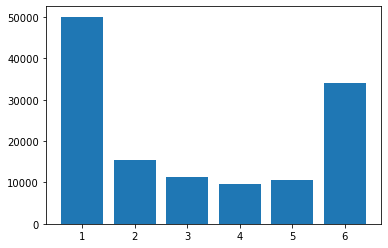

In [57]:
from ranky import rankz

obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)